# Analyzing Baseball Stats

---

## Making Predictions Using Linear and Logistic Regression

Use the machine learning techniques of linear regression and logistic regression to build predictive models using game-level data from baseball.

First, we will focus on the widely used machine learning techniques of linear regression and logistic regression to build predictive models using game-level data. In Part 2, we will focus on the optimization technique of dynamic programming and apply it to in-game decision making. We will also explore another important aspect of data analysis—namely statistical hypothesis testing.

### Part 1 is organized into two sections:

* **Linear regression:** This is about one of the most well-known supervised machine learning algorithms (linear regression) and use it to construct a model for predicting win probabilities from run differentials using scikit-learn. We will also learn how to parse game logs available in the public domain from Retrosheet
* **Logistic regression:** In this section, we will learn about another well-known supervised machine learning algorithm used for categorical data (logistic regression) and use it to construct a model for predicting the outcome of a game from the number of hits using scikit-learn.

In [52]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Linear regression

#### INTRODUCTION
Linear regression is simple, powerful, and probably the most widely used supervised machine learning algorithm. There is a good chance that you will find an application of linear regression in whatever domain you work in—business analytics, sports, healthcare, communications, and sensor data processing, to name a few. In its simplest form, the algorithm determines the parameters of an assumed linear relationship between the response variable Y and the explanatory variable (also called feature or regressor) X of the form Y = aX + b, where a and b are scalars. In the most general case, both Y and X are multidimensional, a is a matrix, and b is a vector. The goal of the learning algorithm is to determine optimal values for the model parameters a and b (optimal in the sense of minimizing the mean squared error between the model estimates and data on the training set). The model can then be used to predict values of Y based on future values of X.

In this section, we will build a simple linear regression model to relate the win percentage of a baseball team to its run differential (i.e., the difference between runs scored and runs allowed). We will use data from five MLB seasons (2011-2015) to train the model and then evaluate the performance of the model on test data from 2016. The game logs used in this segment are sourced from [Retrosheet](http://www.retrosheet.org/). In the process of building the model, we will also learn how to manipulate these game logs in Python using the pandas library. The game logs from Retrosheet are a treasure trove of information and perhaps the most widely used public domain source of data by baseball enthusiasts. Hopefully the illustrative examples presented here will encourage you to construct your own custom analyses and data models using these game logs.

#### DATA PREPROCESSING
The first step in any machine learning endeavor is to process the raw input data to extract relevant "features" and to shape the data into the desired format (known as preprocessing). We will use game logs from the 2018 MLB season as sample input to build up a sequence of methods, which we will later leverage to process game logs from multiple seasons to construct our training and test sets.

The gamelogs from Retrosheet are available as comma-separated text files, with a unique file for each MLB season.

In [53]:
#import zipfile

#input_zip=zipfile.ZipFile("data/GL2018.TXT.zip")
#po=input_zip.read('GL2018.TXT')
#text = po.decode('utf-8')
#input_df = pd.read_csv(text, sep=",", header=None)

In [54]:
import urllib

for year in range(2010, 2019):
    log_file = "GL" + str(year) + ".TXT"
    urllib.request.urlretrieve("https://meriatbackup.blob.core.windows.net/public/retrosheet/"+log_file, "data/"+log_file)
    print(f'File {log_file} done...')

File GL2010.TXT done...
File GL2011.TXT done...
File GL2012.TXT done...
File GL2013.TXT done...
File GL2014.TXT done...
File GL2015.TXT done...
File GL2016.TXT done...
File GL2017.TXT done...
File GL2018.TXT done...


In [55]:
# Read games logs from the 2018 season into a dataframe
input_df = pd.read_csv("data/GL2018.TXT", sep=",", header=None)

In [56]:
input_df.head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,...,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,...,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y
2,20180329,0,Thu,SFN,NL,1,LAN,NL,1,1,...,Yasmani Grandal,2,forsl001,Logan Forsythe,5,kersc001,Clayton Kershaw,1,NaN,Y
3,20180329,0,Thu,CHN,NL,1,MIA,NL,1,8,...,Miguel Rojas,6,wallc001,Chad Wallach,2,urenj001,Jose Urena,1,NaN,Y
4,20180329,0,Thu,SLN,NL,1,NYN,NL,1,4,...,Kevin Plawecki,2,syndn001,Noah Syndergaard,1,rosaa003,Amed Rosario,6,NaN,Y


The dataset comes with unlabeled columns, so as a good practice we will label the columns of interest to make subsequent code more readable. This [web page](http://www.retrosheet.org/gamelogs/glfields.txt) provides a key to what each column of data represents, and is a must-have reference when working with Retrosheet game logs.

In [57]:
# Method to rename columns of an input dataframe (for readability)
# Input type: dataframe
# Output type: dataframe
def rename_cols(input_df):
    input_df.rename(columns = {3: 'Visiting Team', 6: 'Home Team', 9: 'Runs Visitor', 10: 'Runs Home'}, inplace=True)
    return input_df

# Invoke function to rename columns
input_df = rename_cols(input_df)

# Display
input_df.head()

,0,1,2,Visiting Team,4,5,Home Team,7,8,Runs Visitor,...,151,152,153,154,155,156,157,158,159,160
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,...,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,...,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y
2,20180329,0,Thu,SFN,NL,1,LAN,NL,1,1,...,Yasmani Grandal,2,forsl001,Logan Forsythe,5,kersc001,Clayton Kershaw,1,NaN,Y
3,20180329,0,Thu,CHN,NL,1,MIA,NL,1,8,...,Miguel Rojas,6,wallc001,Chad Wallach,2,urenj001,Jose Urena,1,NaN,Y
4,20180329,0,Thu,SLN,NL,1,NYN,NL,1,4,...,Kevin Plawecki,2,syndn001,Noah Syndergaard,1,rosaa003,Amed Rosario,6,NaN,Y


In the next step, we will add new binary-valued columns to the dataframe to indicate whether the home team or the visiting team won the game. It is very easy to generate new columns of data in a dataframe by applying standard or custom functions to existing columns. This greatly simplifies the process of generating new features from a raw data set.

In [58]:
# Method to add new columns to indicate whether home team or visiting team won the game
# Input type: dataframe
# Output type: dataframe
def add_new_cols(input_df):
    input_df['Home Win'] = (input_df['Runs Home'] > input_df['Runs Visitor'])
    input_df['Visitor Win'] = (input_df['Runs Visitor'] > input_df['Runs Home'])
    return input_df

# Invoke method to add new columns
input_df = add_new_cols(input_df)

# Display
input_df.head()

,0,1,2,Visiting Team,4,5,Home Team,7,8,Runs Visitor,...,153,154,155,156,157,158,159,160,Home Win,Visitor Win
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,...,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y,True,False
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,...,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y,True,False
2,20180329,0,Thu,SFN,NL,1,LAN,NL,1,1,...,forsl001,Logan Forsythe,5,kersc001,Clayton Kershaw,1,NaN,Y,False,True
3,20180329,0,Thu,CHN,NL,1,MIA,NL,1,8,...,wallc001,Chad Wallach,2,urenj001,Jose Urena,1,NaN,Y,False,True
4,20180329,0,Thu,SLN,NL,1,NYN,NL,1,4,...,syndn001,Noah Syndergaard,1,rosaa003,Amed Rosario,6,NaN,Y,True,False


We will now use the groupby() method from pandas, which allows us to slice the dataframe into groups (by rows). Specifically, we will apply groupby() to group the data by home team. The same effect can be achieved in principle with a for loop, though using groupby() makes the code more compact and elegant. Next, we will use the apply() method, which allows us to apply the same function (in this case, sum()) to each group created using groupby(). This step will give us the number of wins for the home team; as well as the number of runs scored by the home team and visiting teams. We will also use the count() function to count the total number of home games for each team. The results are stored in a dataframe called home_df.

In [59]:
# Method to group data by home team and compute relevant statistics
# Input type: dataframe
# Output type: dataframe (with stats grouped by home team)
def proc_home_team_data(input_df):

    # Group by home team
    home_group = input_df.groupby(input_df['Home Team'])

    # Compute stats: Number of games, runs scored, runs conceded, wins, run differential
    home_df = home_group[['Runs Visitor', 'Runs Home', 'Home Win']].apply(sum)
    home_df['Home Games'] = home_group['Home Win'].count()
    home_df.rename(columns = {'Runs Visitor': 'Runs by Visitor', 'Runs Home': 'Runs at Home', 'Home Win': 'Wins at Home'}, inplace=True)
    home_df['RD at Home'] = home_df['Runs at Home'] - home_df['Runs by Visitor']
    home_df.index.rename('Team', inplace=True)
    home_df.reset_index(inplace=True)

    return home_df

# Invoke method to group data by home team and compute statistics
home_df = proc_home_team_data(input_df)

# Display
home_df.head()

,Team,Runs by Visitor,Runs at Home,Wins at Home,Home Games,RD at Home
0,ANA,355.0,355.0,42.0,81,0.0
1,ARI,328.0,359.0,40.0,81,31.0
2,ATL,357.0,391.0,43.0,81,34.0
3,BAL,411.0,339.0,28.0,81,-72.0
4,BOS,322.0,468.0,57.0,81,146.0


In this step, we will group the data by visiting team and apply similar computations as described in the previous step to create the visit_df dataframe.

In [60]:
# Method to group data by visiting team and compute relevant statistics
# Input type: dataframe
# Output type: dataframe (with stats grouped by visiting team)
def proc_visiting_team_data(input_df):

    # Group by visiting team
    visit_group = input_df.groupby(input_df['Visiting Team'])

    # Compute stats: Number of games, runs scored, runs conceded, wins, run differential
    visit_df = visit_group[['Runs Visitor', 'Runs Home', 'Visitor Win']].apply(sum)
    visit_df['Road Games'] = visit_group['Visitor Win'].count()
    visit_df.rename(columns = {'Runs Visitor': 'Runs as Visitor', 'Runs Home': 'Runs by Home', 
                                 'Visitor Win': 'Wins as Visitor'}, inplace=True)
    visit_df['RD as Visitor'] = visit_df['Runs as Visitor'] - visit_df['Runs by Home']
    visit_df.index.rename('Team', inplace=True)
    visit_df.reset_index(inplace=True)

    return visit_df

# Invoke method to group data by visiting team and compute statistics
visit_df = proc_visiting_team_data(input_df)

# Display
visit_df.head()

,Team,Runs as Visitor,Runs by Home,Wins as Visitor,Road Games,RD as Visitor
0,ANA,366.0,367.0,38.0,81,-1.0
1,ARI,334.0,316.0,42.0,81,18.0
2,ATL,368.0,300.0,47.0,81,68.0
3,BAL,283.0,481.0,19.0,81,-198.0
4,BOS,408.0,325.0,51.0,81,83.0


Finally, we will use the merge() function to merge the home_df and visit_df dataframes into one dataframe, named overall_df. The merge() function allows us to join columns from two different dataframes with the same row names. In our example, this has the effect of joining the home and away records for each team per row. To make our explanatory and response variables explicit, we will add two new columns to overall_df—namely RD (run differential) and Win Pct (win percentage). These are easily computed from columns already in the dataframe.

In [61]:
# Method to merge dataframes with statistics grouped by home and visiting teams
# and to explicitly compute explanatory and response variables
# Input type: dataframe, dataframe
# Output type: dataframe
def merge_data_frames(home_df, visit_df):
    # Compute explanatory and response variables
    overall_df = home_df.merge(visit_df, how='outer', left_on='Team', right_on='Team')
    overall_df['RD'] = overall_df['RD at Home'] + overall_df['RD as Visitor']
    overall_df['Win Pct'] = (overall_df['Wins at Home'] + overall_df['Wins as Visitor']) / (overall_df['Home Games'] + overall_df['Road Games'])

    # Return dataframe with explanatory and response variables
    return overall_df

# Invoke method to merge home and visitor dataframes
overall_df = merge_data_frames(home_df, visit_df)

# Display
overall_df.head()

,Team,Runs by Visitor,Runs at Home,Wins at Home,Home Games,RD at Home,Runs as Visitor,Runs by Home,Wins as Visitor,Road Games,RD as Visitor,RD,Win Pct
0,ANA,355.0,355.0,42.0,81,0.0,366.0,367.0,38.0,81,-1.0,-1.0,0.493827
1,ARI,328.0,359.0,40.0,81,31.0,334.0,316.0,42.0,81,18.0,49.0,0.506173
2,ATL,357.0,391.0,43.0,81,34.0,368.0,300.0,47.0,81,68.0,102.0,0.555556
3,BAL,411.0,339.0,28.0,81,-72.0,283.0,481.0,19.0,81,-198.0,-270.0,0.290123
4,BOS,322.0,468.0,57.0,81,146.0,408.0,325.0,51.0,81,83.0,229.0,0.666667


To streamline our processing of game logs from multiple years, we will now create a wrapper method called extract_linear_reg_inputs(), which simply invokes the methods we developed above in sequence and returns a processed dataframe with the explanatory and response variables.

In [62]:
# Method to collate all data preprocessing steps
# Input type: dataframe
# Output type: dataframe
def extract_linear_reg_inputs(input_df):
    # Rename columns
    input_df = rename_cols(input_df)

    # Add new columns
    input_df = add_new_cols(input_df)

    # Group and process data by home team
    home_df = proc_home_team_data(input_df)

    # Group and process data by visiting team
    visit_df = proc_visiting_team_data(input_df)

    # Merge home and visitor dataframes
    overall_df = merge_data_frames(home_df, visit_df)

    return overall_df

#### MODEL CONSTRUCTION AND EVALUATION

**Constructing the training set**

Equipped with the method extract_linear_reg_inputs(), we will build our training data set, which will be used to estimate the parameters of the linear regression model.

We will use data from five MLB seasons (2011-2015) to train the model. Our strategy will be to construct a training set combining all five seasons of interest by looping over seasons, loading the game log of each season in the loop by using read_table(), extracting the response and explanatory variables by calling our extract_linear_reg_inputs() method, and accumulating relevant columns from the returned dataframe into NumPy arrays (initialized outside the for loop) to construct the training data.

In [63]:
# Get training data from 2010-2017 to train the linear regression model

# Initialize arrays to hold training data
train_run_diff = np.empty([0, 1])
train_win_pct = np.empty([0, 1])

# Loop
for year in range(2010, 2018):
    # Construct log file name
    log_file = "data/GL" + str(year) + ".TXT"
    print(log_file)
    # Read log into a dataframe
    df = pd.read_csv(log_file, sep=",", header=None)

    # Extract relevant stats into another dataframe
    df_proc = extract_linear_reg_inputs(df)

    # Add to training set
    train_run_diff = np.vstack([train_run_diff, df_proc['RD'].values.reshape([-1, 1])])
    train_win_pct = np.vstack([train_win_pct, df_proc['Win Pct'].values.reshape([-1, 1])])

data/GL2010.TXT
data/GL2011.TXT
data/GL2012.TXT
data/GL2013.TXT
data/GL2014.TXT
data/GL2015.TXT
data/GL2016.TXT
data/GL2017.TXT


**Building the model and interpreting the parameters**

We will now use the LinearRegression class imported from scikit-learn to compute our model parameters. As a first step, we will instantiate an object for the linear model.

In [64]:
# Instantiate an object
lin_regr = linear_model.LinearRegression(fit_intercept=True)

Next, we will train the model by passing it the training data set constructed above.

In [65]:
# Compute model parameters with training data
lin_regr.fit(train_run_diff, train_win_pct)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

The model parameters a and b (slope and intercept, respectively) can be accessed as attributes of the linear regression object, as shown next.

In [66]:
# Access and display model parameters
print("Slope (a) = ", float(lin_regr.coef_), " Intercept (b) = ", float(lin_regr.intercept_))

Slope (a) =  0.0006089801297614885  Intercept (b) =  0.4999711239869727


We will now compute the R2 (R-squared) value of the fit using the score() method. R2 (a number between 0 and 1) is the most commonly used metric for evaluating the goodness of a linear fit. A value of 1.0 indicates a perfect fit. Intuitively, R2 captures the proportion of variation in the response variable, which can be defined by the explanatory variable.

In [67]:
# Get regression score (R-squared)
r_squared = lin_regr.score(train_run_diff, train_win_pct)
print("R-squared for linear fit = ", r_squared)

R-squared for linear fit =  0.8693910755423705


For our example, an R2 value of 0.863 indicates a very good fit.

For baseball enthusiasts, it should be an interesting exercise to compare the results of this model with the widely used [Pythagorean Expected Win-Loss Formula](https://en.wikipedia.org/wiki/Pythagorean_expectation) coined by sabermetrics guru Bill James.

Finally, we will visualize our test data and fit using routines from matplotlib, which is the most widely used plotting routine for numerical and scientific computing. Visually exploring the relationships between the response and explanatory variables is an important step in model construction and aids in good feature selection.

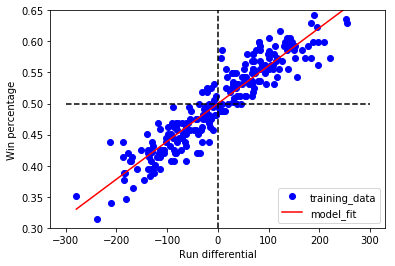

In [68]:
# Visualize
x_ax = np.array(range(int(np.min(train_run_diff)), int(np.max(train_run_diff)))).reshape(-1, 1)
y_ax = lin_regr.coef_ * x_ax + lin_regr.intercept_
plt.plot(train_run_diff, train_win_pct, 'bo', label="training_data")
plt.plot(x_ax, y_ax, 'r', label="model_fit")
plt.plot([-300, 300], [0.5, 0.5], "k--")
plt.plot([0, 0], [0.30, 0.65], "k--")
plt.ylim([0.30, 0.65])
plt.xlabel("Run differential")
plt.ylabel("Win percentage")
plt.legend(loc="lower right")
plt.show()

There are a couple of interesting observations to draw from the model parameter values computed above and the visualization:

The slope value tells us that an approximately 16-run increase in run differential maps to a 1% increase in win probability.
The intercept value tells us that a team with a 0-run differential is expected to win roughly half of its games.

**Evaluating the model on test data**

As the last step in this exercise, we will evaluate the model constructed above on a test data set, which in this case is game data from 2016. In the preprocessing phase, we will follow steps identical to what we did for loading, parsing, and extracting features from the training data.

In [70]:
# Construct test dataset
log_file = "data/GL2018.TXT"
df = pd.read_csv(log_file, sep=",", header=None)
df_proc = extract_linear_reg_inputs(df)
test_run_diff = df_proc['RD'].values.reshape([-1, 1])
test_win_pct = df_proc['Win Pct'].values.reshape([-1, 1])

Next, we will use the predict() method to apply the model to the test data and estimate 2016 win percentages based on run differentials.

In [71]:
# Predict outcomes using regression model
predict_win_pct = lin_regr.predict(test_run_diff)

We will use the percentage error between the results predicted by the model and the true answer (available from the game logs), averaged over the entire data set, to quantify how well the model performed on the test set relative to the training set. In this application, we don't particularly care whether the model overestimated or underestimated the win probability, so we will use the absolute value of the error as our performance metric.

In [72]:
# Compute percentage error for linear regression model on test set
mean_abs_error_test = np.mean(np.abs(predict_win_pct - test_win_pct))
print("Percentage error on test set = ", 100. * mean_abs_error_test, "%")

# Compute percentage error for linear regression model on training set
model_fit_train = lin_regr.predict(train_run_diff)
mean_abs_error_training = np.mean(np.abs(model_fit_train - train_win_pct))
print("Percentage error on training set ", 100. * mean_abs_error_training, "%")

Percentage error on test set =  2.0850991742045375 %
Percentage error on training set  1.9289683164333808 %


The analysis shows that the performance of the model on the test set is almost as good as the performance on the training set. To wrap up, we will visualize the actual and predicted win percentages with reference to a 45 degree line.

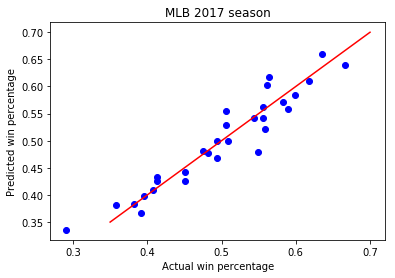

In [73]:
# Visualize
plt.plot(test_win_pct, predict_win_pct, 'bo')
plt.plot([0.35, 0.7], [0.35, 0.7], 'r')
plt.xlabel("Actual win percentage")
plt.ylabel("Predicted win percentage")
plt.title("MLB 2017 season")
plt.show()

Exercise: Can you show that the model was most inaccurate (by 8.1%) for the Texas Rangers, who had a run differential of only +8 runs, but ended up winning 58.6% of their games (the model predicted 50.5%)?

Hint: Use the np.argmax() method to find the index at which the prediction error is maximized, and the np.max() method to find the corresponding maximum value. The index value can then be used to find the appropriate row in the df_proc dataframe (which contains the entire test dataset) and subsequently the name of the team.

**Multiple regressors**

Even though we only covered the single regressor case here as an illustration, it is relatively straightforward to extend the above methodology to the multiple regressor case. For instance, with two regressors, one would end up with a relationship of the form Y = a1X1 + a2X2 + b, where Y is the response variable, a1 and a2 are the regression coefficients, and b is the intercept. For the example we covered, it would be an interesting exercise to use "runs scored" and "runs allowed" as separate regressors (instead of combining them into one feature in the form of a differential) to see if that improves the prediction power of the model.

Exercise: Can you quantify the improvement in model performance if "runs scored" and "runs allowed" are used as separate regressors (instead of linearly combining them into one feature with equal weights of opposite sign to create the run differential)? It turns out that the regression coefficients for the two regressors are 0.00058197 and -0.00069973, respectively, which have opposite sign (as expected), but are not equal in magnitude. The R2 value of this model is 0.87, only slightly higher than the single regressor model.

Hint: Use the sum of the columns "Runs at Home" and "Runs as Visitor" in the training set dataframe to create the runs_scored feature. Similarly, use the sum of the columns "Runs by Home" and "Runs by Visitor" to create the runs_allowed feature. Instantiate the linear regression fit using lin_regr.fit(feature, train_win_pct), where feature = np.hstack([runs scored, runs_allowed]) contains the two regressors as separate columns. The model coefficients, R2 and predictions can be computed similar to the single regressor case.

One note of caution when incorporating multiple regressors into a model is to make sure that the regressors are roughly independent (in a statistical sense); otherwise, the model could get overly complex without necessarily adding more predictive capability. In our example, if we were using "runs scored" as a regressor, it would be superfluous to use "team OPS" (on-base plus slugging %) as an additional feature, since it would likely have a very high correlation with "runs scored". On the other hand, one can expect "runs scored" and "runs allowed" to be largely independent (i.e., good offense does not imply good defense, and vice versa).

**Feature transformation**

Even though we have been focused on the case where the relationship between the explanatory variable and the regressor is of the form Y = aX + b, the framework easily extends to the case where the relationship is of the form Y = af(X) + b (where f(.) is a function/mapping). In the simplest case (i.e., linear), f(X) = X. A mapping of the form f(X) = X2 would imply a quadratic relationship between Y and X, f(X) = X3 would imply a cubic relationship, and so on. It is imperative to explore this relationship visually before embarking on the modeling exercise and transforming the selected feature appropriately in the data preprocessing phase.

Exercise: Can you use feature transformation to evaluate the Pythagorean Expected Win-Loss Formula and come up with the best exponent value?

Hint: Building on the previous exercise, create the feature f = zα/(1 + zα), where z is the ratio of runs_scored to runs_allowed and α is the exponent of choice. The feature can be created using the np.divide() and np.power() methods. Now follow the usual steps of setting up and evaluating a linear regression model, but instantiate the model as lin_regr = linear_model.LinearRegression(fit_intercept=False) to force the intercept to be 0. Write a for loop to sweep over α and find the value that minimizes the error on the training set.

## Logistic regression

In the previous section, we used linear regression to express our response variable as a linear function of the explanatory variable. For the case where the response variable is categorical, logistic regression provides a more natural modeling framework. We will specifically focus on the case of a binary-valued (e.g., 0 or 1) response variable. In logistic regression, instead of expressing the response variable directly as a function of the explanatory variable, we express the probability of the response variable being equal to 1 (or 0) as a function of the explanatory variable. Specifically, the mapping is obtained by applying the standard logistic function to a linear combination of the explanatory variables. The relationship is mathematically expressed as Y = 1 / (1 + e-(aX+b)). Since the range of the logistic function is [0, 1], the result of the mapping can be interpreted as a probability. Just like linear regression, logistic regression is a simple yet powerful and widely used machine learning technique with applications in diverse areas such as modeling healthcare outcomes, horse racing, and stock trading.

To make the idea concrete, we will use logistic regression to model the outcome of a game (from the point of view of the home team) as a function of the number of hits amassed by the home team. Let's define a "0" outcome as a loss for the home team and a "1" as a win for the home team. It is intuitive to expect that getting more hits increases the chances of victory. Through model fitting, we will explore if we can quantify this intuition.

### TRAINING SET AND MODEL CONSTRUCTION

Similar to the linear regression case, we will use Retrosheet game logs from five MLB seasons (2011-2015) to construct our training set. The explanatory variable in this case, number of hits by home team, is readily available in the raw data, so no additional processing for feature extraction is required. We will construct a Boolean-valued column to indicate whether the home team won the game (1/True) or not (0/False), just like we did in the linear regression example. We will aggregate these columns of data into NumPy arrays to create our training data set.

In [76]:
# Get training data from 2011-2015 to train the logistic regression model

# Initialize arrays to hold training data
train_num_hits = np.empty([0, 1])
train_win_label = np.empty([0, 1])

# Loop
for year in range(2010, 2017):
    # Construct log file name
    log_file = "data/GL" + str(year) + ".TXT"

    # Read log into a dataframe
    df = pd.read_csv(log_file, sep=",", header=None)

    # Rename columns for readability
    df.rename(columns = {6: 'Home Team', 9: 'Runs Visitor', 10: 'Runs Home', 50: 'Hits Home'}, inplace=True)

    # Add new columns to indicate whether home team or visiting team won the game
    df['Home Win'] = (df['Runs Home'] > df['Runs Visitor'])

    # Add to training set
    train_num_hits = np.vstack([train_num_hits, df['Hits Home'].values.reshape([-1, 1])])
    train_win_label = np.vstack([train_win_label, df['Home Win'].values.reshape([-1, 1])])

Next, we will create an instance of the logistic regression model (using the LogisticRegression class from scikit-learn). The class offers a variety of configuration options related to the objective function and algorithm used for parameter optimization, parameter regularization, etc., which I encourage you to read more about [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). For this exercise, we will just use the default settings.

In [78]:
# Instantiate logistic regression object
log_regr = linear_model.LogisticRegression()

We will now train the model by passing it the training data set constructed above.

In [79]:
# Fit model to training data
log_regr.fit(train_num_hits, train_win_label.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The model parameters a and b are available as attributes and can be accessed as "coef_" and "intercept_" respectively, as shown below.

In [80]:
print("Slope = ", float(log_regr.coef_), " Intercept = ", float(log_regr.intercept_))

Slope =  0.24586571434549434  Intercept =  -1.9354170126789547


We will quantify how well the model performed by calling the score() method. The method returns the proportion of the training set on which the label (in this case, 0 or 1) was predicted correctly by the model.

In [81]:
# Get performance score
log_regr_score_train = log_regr.score(train_num_hits, train_win_label.ravel())
print("Percentage correct on training set = ", 100. * log_regr_score_train, "%")

Percentage correct on training set =  65.1731639912977 %


In this example, the model has a 64.7% success rate on the training set.

The probability mapping for the training data will be constructed using a for loop, which bins the win probability by number of hits.

In [82]:
# Estimate the probability of home team winning the game as a function of number
# of hits from the training data
hits_range = np.arange(np.min(train_num_hits), np.max(train_num_hits))
prob_est_train_data = np.zeros([len(hits_range), 1])
for hits in hits_range:
    index = np.where(train_num_hits == hits)
    if len(index[0]) > 0:
        prob_est_train_data[int(hits - np.min(train_num_hits))] = np.sum(train_win_label[index[0]]) / len(index[0])

The model fit will be accessed using the method predict_proba(), which returns the probability of the data point belonging to each class/label.

In [83]:
# Get the probabilities as estimated by the model
prob_est_model = log_regr.predict_proba(train_num_hits)

Finally, we will visualize the training data and the model fit using matplotlib. We can see that the model fits the training data reasonably well for 6 or more hits, but diverges for fewer hits.

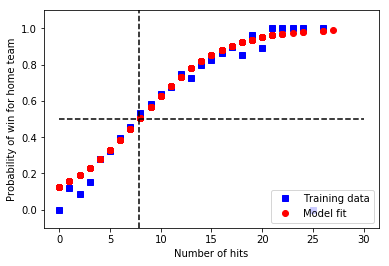

In [84]:
# Plot and visualize input and estimated probabilities
plt.plot(hits_range, prob_est_train_data, 'bs', label="Training data")
plt.plot(train_num_hits, prob_est_model[:, 1], 'ro', label="Model fit")
plt.plot([0, 30], [0.5, 0.5], "k--")
plt.plot([7.89, 7.89], [-0.1, 1.1], "k--")
plt.ylim([-0.1, 1.1])
plt.legend(loc="lower right")
plt.xlabel("Number of hits")
plt.ylabel("Probability of win for home team")
plt.show()

There are a couple of interesting observations to draw from the model parameter values computed previously and the visualization:

* At X = 0, Y = 1 / (1 + e-b), which means that the model gives the home team a 13% chance of winning the game even if it registers zero hits. While this scenario is definitely not impossible, it does create a bias in the predictions for small values of X.
* At X = -b / a = 7.89, Y = 0.5, which means the model gives the home team about a 50% chance of winning if it gets 7 or 8 hits. This implies that the model is most uncertain in predicting a home win when the number of hits is 7 or 8, but gets more confident as we move away in either direction.

**EVALUATING THE MODEL ON TEST DATA**

As the last step in this section, we will evaluate the logistic regression model developed above on a test data set (once again, the game logs from the 2016 MLB season).

First, we will preprocess the raw dataframe using steps identical to what we did when constructing the training data set.

In [86]:
# Evaluate model
log_file = "data/GL2016.TXT"
df = pd.read_csv(log_file, sep=",", header=None)

# Rename columns for readability
df.rename(columns = {6: 'Home Team', 9: 'Runs Visitor', 10: 'Runs Home', 50: 'Hits Home'}, inplace=True)

# Add new columns to indicate whether home team or visiting team won the game
df['Home Win'] = (df['Runs Home'] > df['Runs Visitor'])

# Construct test data
test_num_hits = df['Hits Home'].values.reshape([-1, 1])
test_win_label = df['Home Win'].values.reshape([-1, 1])

Next, we will use the predict() method to predict wins and losses for the home team based on the number of hits amassed by the home team.

In [87]:
# Prediction
predict_win_label = log_regr.predict(test_num_hits)

Then we will evaluate the overall performance of the model on the test set using the score() method.

In [88]:
# Get score
log_regr_score_test = log_regr.score(test_num_hits, test_win_label.ravel())
print("Percentage correct on test set = ", 100. * log_regr_score_test, "%")

Percentage correct on test set =  66.76276771004942 %


The analysis returns a classification accuracy of 66.8% on the test set, which is actually marginally higher than the 64.7% score obtained on the training set.

Finally, we will quantify the accuracy of the model as a function of number of hits. We will do this using a for loop to bin model accuracy as a function of the number of hits and store them in a variable called frac_correct.

In [89]:
# Evaluate performance for each value of X
delta = np.abs(test_win_label.ravel() - predict_win_label.ravel())
hits_range = np.arange(np.min(test_num_hits), np.max(test_num_hits))
frac_correct = np.zeros([len(hits_range), 1])
for hits in hits_range:
    index_all = np.where(test_num_hits == hits)
    index_correct = np.where((test_num_hits.ravel() == hits) & (delta.ravel() == 0))
    frac_correct[int(hits - np.min(test_num_hits))] = len(index_correct[0]) / len(index_all[0])

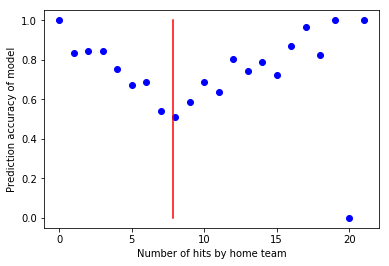

In [90]:
# In the last step, we will visualize frac_correct.
# Plot
plt.plot(hits_range, frac_correct,'bo')
plt.xlabel("Number of hits by home team")
plt.ylabel("Prediction accuracy of model")
mid_point = -1. * float(log_regr.intercept_) / float(log_regr.coef_) 
plt.plot([mid_point, mid_point], [0, 1], 'r')
plt.show()

As we have discussed previously, the model accuracy is at its lowest when the home team gets 7 or 8 hits and improves as we move away in either direction. It would be an interesting exercise to find out if incorporating more features (e.g., walks or extra base hits) into this model can help improve the prediction accuracy. That would certainly be in line with [Moneyball](https://en.wikipedia.org/wiki/Moneyball) thinking, which values on-base percentage over hits.

### Wrapping up

Statistical analysis is an integral aspect of the game of baseball. The availability of detailed game data in the public domain, the rapidly growing interest in data science in virtually every industry, and the powerful data analysis and machine learning libraries now available in scripting languages like Python and MATLAB makes this an exciting time for delving deeper into the field of baseball statistical analysis.

In Part 1 of this Oriole, we looked at two popular machine learning techniques, namely linear regression and logistic regression, to do interesting analyses and visualization of baseball data retrieved from [Retrosheet](http://www.retrosheet.org/). Even though we used baseball data from only one (albeit very popular) source, there are several other public domain sources of baseball data that can be used to perform different kinds of analyses. For instance, Retrosheet also offers [play-by-play](http://www.retrosheet.org/game.htm) logs in addition to game logs, which allows for a very [granular analysis](http://seanlahman.com/baseball-archive/statistics). The Lahman database is another great source of raw data amenable to analysis in Python. Additionally, websites like [FanGraphs](http://www.fangraphs.com/), [Baseball-Reference](http://www.baseball-reference.com/), and [PITCHf/x](http://www.brooksbaseball.net/pfxVB/pfx.php?) provide copious amounts of precalculated statistics to whet your appetite and provide you interesting directions to pursue for your own baseball data analysis journey.

The concepts demonstrated here are widely applicable and I hope you will find relevant use cases in your domains of interest beyond baseball. For instance, in the healthcare domain, one could apply logistic regression to model and eventually predict the outcome of a drug or treatment (success/failure) as a function of medication adherence and other physiologic biomarkers (e.g., blood pressure or resting heart rate). In the real estate world, one could use multivariate linear regression to model and predict home prices as a function of attributes such as square footage, number of bedrooms, proximity to schools, etc.